In [1]:
!ls sample_image

multiperson.jpg  ski.jpg


In [2]:
## Include mxnet path: you should include your mxnet local path, if mxnet path is global, 
## you don't need to include it.
import sys
sys.path.append('/data/guest_users/liangdong/liangdong/practice_demo')
import os
import mxnet as mx
import numpy as np
import copy
import re
from google.protobuf import text_format
import json
import cv2 as cv
import scipy
import PIL.Image
import math
import time
import scipy
import matplotlib
%matplotlib inline
import pylab as plt
from scipy.ndimage.filters import gaussian_filter
from modelCPMWeight import *
from collections import namedtuple
Point = namedtuple('Point', 'x y')
crop_size_x = 368
crop_size_y = 368
center_perterb_max = 40

#use_caffe = True
scale_prob = 1
scale_min = 0.5
scale_max = 1.1
target_dist = 0.6

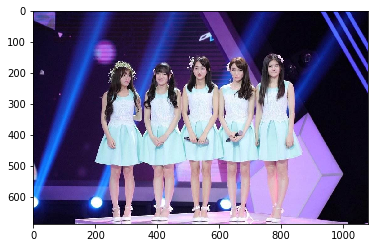

In [3]:
# imgsequence = 2000
# datas[keyss[imgsequence]]['img_paths']
path = 'sample_image/multiperson.jpg'
cimage = cv.imread(path)
plt.imshow(cimage[:, :, [2,1,0]])

In [55]:
output_prefix='testConfigModel'
sym, arg_params, aux_params = mx.model.load_checkpoint(output_prefix, 55)

In [56]:
csym = CPMModel_test()

In [79]:
def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h%stride==0) else stride - (h % stride) # down
    pad[3] = 0 if (w%stride==0) else stride - (w % stride) # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1,:,:]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:,0:1,:]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1,:,:]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:,-2:-1,:]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad

class DataBatch(object):
    def __init__(self, data, label, pad=0):
        self.data = [data]
        self.label = [label]
        self.pad = pad

def applyDNN(oriImg, images, sym1, arg_params1, aux_params1):
    
    imageToTest_padded, pad = padRightDownCorner(images, 8, 128)
    transposeImage = np.transpose(np.float32(imageToTest_padded[:,:,:]), (2,0,1))/256 - 0.5
    testimage = transposeImage
    # print testimage.shape
    cmodel = mx.mod.Module(symbol=csym, label_names=[], context=mx.cpu())
    print testimage.shape
    cmodel.bind(data_shapes=[('data', (1, 3, testimage.shape[1], testimage.shape[2]))])
    cmodel.init_params(arg_params=arg_params1, aux_params=aux_params1)
    # print 'init_params failed'
    onedata = DataBatch(mx.nd.array([testimage[:,:,:]]), 0)
    #print 'batch'
    cmodel.forward(onedata)
    #print 'forward'
    result = cmodel.get_outputs()
    
    print(type(result))
    print(len(result))
    
            
    #heatmap = np.moveaxis(result[1].asnumpy()[0], 0, -1)
    # heatmap = np.moveaxis(result[0].asnumpy()[0], 0, 1)
    heatmap = np.moveaxis(result[11].asnumpy()[0], 0, -1)
    heatmap = cv.resize(heatmap, (0,0), fx=8, fy=8, interpolation=cv.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
    
    # pagmap = np.moveaxis(result[0].asnumpy()[0], 0, -1)
    pagmap = np.moveaxis(result[10].asnumpy()[0], 0, -1)
    pagmap = cv.resize(pagmap, (0,0), fx=8, fy=8, interpolation=cv.INTER_CUBIC)
    pagmap = pagmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    pagmap = cv.resize(pagmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
    
    print heatmap.shape
    print pagmap.shape
    return heatmap, pagmap

def applyModel(oriImg, param, sym, arg_params, aux_params):
    model = param['model']
    model = model[param['modelID']]
    boxsize = model['boxsize']
    # print(model)
    # print(boxsize)
    makeFigure = 0 
    numberPoints = 1
    octave = param['octave']
    starting_range = param['starting_range']
    ending_range = param['ending_range'] 
    # print starting_scale, ending_scale
    '''
    starting_range = 0.85 # 0.25 0.7
    ending_range = 1.5    # 1.2 1.8
    octave = 6
    starting_scale = boxsize*1.0/(oriImg.shape[0]*ending_range)
    ending_scale = boxsize*1.0/(oriImg.shape[0]*starting_range)
    multiplier = list()
    current_scale = math.log(starting_scale, 2)
    while current_scale < math.log(ending_scale, 2):
        # print current_scale
        multiplier.append(pow(2, current_scale))
        current_scale = current_scale+(1.0/octave)
    multiplier = [0.5, 1, 1.5, 2]
    '''
    # numofparts = 15
    # numoflinks = 13
    boxsize = 368
    scale_search = [0.5, 1, 1.5, 2]
    multiplier = [x * boxsize*1.0/ oriImg.shape[0] for x in scale_search] 
    # if x * boxsize*1.0/ oriImg.shape[0]*oriImg.shape[1]<2000]
    
    print multiplier
    
    heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], numofparts))
    pag_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], numoflinks*2))
    for i in range(len(multiplier)):
        # print i
        cscale = multiplier[i]
        imageToTest = cv.resize(oriImg, (0,0), fx=cscale, fy=cscale, interpolation=cv.INTER_CUBIC)
        
        heatmap, pagmap = applyDNN(oriImg, imageToTest, sym, arg_params, aux_params)
        # print(heatmap.shape)
        # print(pagmap.shape)
        heatmap_avg = heatmap_avg + heatmap / len(multiplier)
        pag_avg = pag_avg + pagmap / len(multiplier)
        # print 'add one layer'
    return heatmap_avg, pag_avg

In [80]:
if len(cimage.shape)==2:
    cimgRGB = np.zeros((cimage.shape[0], cimage.shape[1], 3))
    for i in range(3):
        cimgRGB[:, :, i] = cimage
    print cimgRGB.shape
else:
    cimgRGB = cimage

In [81]:
modelId = 1
# set this part
param = dict()
# GPU device number (doesn't matter for CPU mode)
GPUdeviceNumber = 0
# Select model (default: 5)
param['modelID'] = modelId
# Use click mode or not. If yes (1), you will be asked to click on the center
# of person to be pose-estimated (for multiple people image). If not (0),
# the model will simply be applies on the whole image.
param['click'] = 1
# Scaling paramter: starting and ending ratio of person height to image
# height, and number of scales per octave
# warning: setting too small starting value on non-click mode will take
# large memory
# CPU mode or GPU mode
param['use_gpu'] = 1
param['test_mode'] = 3
param['vis'] = 1
param['octave'] = 6
param['starting_range'] = 0.8
param['ending_range'] = 2
param['min_num'] = 4
param['mid_num'] = 10
# the larger the crop_ratio, the smaller the windowsize
param['crop_ratio'] = 2.5  # 2
param['bbox_ratio'] = 0.25 # 0.5
# applyModel_max
param['max'] = 0
# use average heatmap
param['merge'] = 'avg'

# path of your caffe
caffepath = '/home/zhecao/caffe/matlab';

if modelId == 1:
    param['scale_search'] = [0.5, 1, 1.5, 2]
    param['thre1'] = 0.1
    param['thre2'] = 0.05 
    param['thre3'] = 0.5 

    param['model'] = dict()
    param['model'][1] = dict()
    param['model'][1]['caffemodel'] = '../model/_trained_COCO/pose_iter_440000.caffemodel'
    param['model'][1]['deployFile'] = '../model/_trained_COCO/pose_deploy.prototxt'
    param['model'][1]['description'] = 'COCO Pose56 Two-level Linevec'
    param['model'][1]['boxsize'] = 368
    param['model'][1]['padValue'] = 128
    param['model'][1]['np'] = 18
    param['model'][1]['part_str'] = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 
                             'Lsho', 'Lelb', 'Lwri', 
                             'Rhip', 'Rkne', 'Rank',
                             'Lhip', 'Lkne', 'Lank',
                             'Leye', 'Reye', 'Lear', 'Rear', 'pt19']
if modelId == 2:
    param['scale_search'] = [0.7, 1, 1.3]
    param['thre1'] = 0.05
    param['thre2'] = 0.01 
    param['thre3'] = 3
    param['thre4'] = 0.1

    param['model'] = dict()
    param['model'][2] = dict()
    param['model'][2]['caffemodel'] = '../model/_trained_MPI/pose_iter_146000.caffemodel'
    param['model'][2]['deployFile'] = '../model/_trained_MPI/pose_deploy.prototxt'
    param['model'][2]['description'] = 'COCO Pose56 Two-level Linevec'
    param['model'][2]['boxsize'] = 368
    param['model'][2]['padValue'] = 128
    param['model'][2]['np'] = 18
    param['model'][2]['part_str'] = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri',  
                                     'Lsho', 'Lelb', 'Lwri', 
                                     'Rhip', 'Rkne', 'Rank', 
                                     'Lhip', 'Lkne', 'Lank', 
                                     'Leye', 'Reye', 'Lear', 'Rear', 'pt19']

In [82]:
heatmap_avg, paf_avg = applyModel(cimgRGB, param, sym, arg_params, aux_params)
print heatmap_avg.shape
print paf_avg.shape

[0.2678311499272198, 0.5356622998544396, 0.8034934497816594, 1.0713245997088792]
(3, 184, 296)
self._data_shapes:  [DataDesc[data,(1, 3, 184, 296),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
<type 'list'>
12
(687, 1080, 15)
(687, 1080, 26)
(3, 368, 584)
self._data_shapes:  [DataDesc[data,(1, 3, 368, 584),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
<type 'list'>
12
(687, 1080, 15)
(687, 1080, 26)
(3, 552, 872)
self._data_shapes:  [DataDesc[data,(1, 3, 552, 872),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
<type 'list'>
12
(687, 1080, 15)
(687, 1080, 26)
(3, 736, 1160)
self._data_shapes:  [DataDesc[data,(1, 3, 736, 1160),<type 'numpy.float32'>,NCHW]]
self._label_shapes:  None
<type 'list'>
12
(687, 1080, 15)
(687, 1080, 26)
(687, 1080, 15)
(687, 1080, 26)


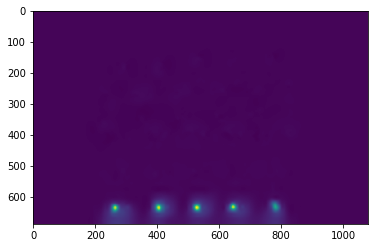

In [83]:
plt.imshow(heatmap_avg[:, :, 8])

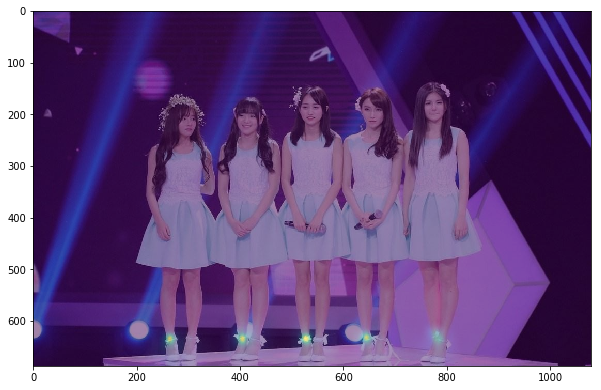

In [84]:
# 1/右肩	2/右肘	3/右腕	4/左肩	5/左肘
# 6/左腕	7/右髋	8/右膝	9/右踝	10/左髋
# 11/左膝	12/左踝	13/头顶	14/脖子
f = plt.figure(1)
plt.imshow(cimgRGB[:, :, [2,1,0]])
ax2 = plt.imshow(heatmap_avg[:, :, 8], alpha=.5)
f.show()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

In [85]:
paf_avg.shape

(687, 1080, 26)

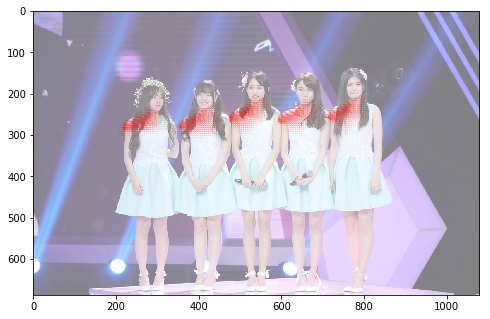

In [86]:
# mid_1 = [13,  1,  4, 1, 2, 4, 5, 1, 7, 8,  4, 10, 11]
# mid_2 = [14, 14, 14, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]

from numpy import ma
#pagmapScale0 = paf_avg[:, :, 24]#cv.resize(paf_avg[0], (0, 0), fx=8, fy=8)
#pagmapScale1 = paf_avg[:, :, 25]#cv.resize(paf_avg[1], (0, 0), fx=8, fy=8)
pagmapScale0 = paf_avg[:, :, 2]#cv.resize(paf_avg[0], (0, 0), fx=8, fy=8)
pagmapScale1 = paf_avg[:, :, 3]#cv.resize(paf_avg[1], (0, 0), fx=8, fy=8)
#pagmapScale0 = paf_avg[:, :, 24]#cv.resize(paf_avg[0], (0, 0), fx=8, fy=8)
#pagmapScale1 = paf_avg[:, :, 25]#cv.resize(paf_avg[1], (0, 0), fx=8, fy=8)
#pagmapScale0 = paf_avg[:, :, 0]#cv.resize(paf_avg[0], (0, 0), fx=8, fy=8)
#pagmapScale1 = paf_avg[:, :, 1]#cv.resize(paf_avg[1], (0, 0), fx=8, fy=8)
U = pagmapScale0 * -1
V = pagmapScale1
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.1*0.1] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(cimgRGB[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)

In [87]:
# print 'heatmap, paf'
all_peaks = []
peak_counter = 0

for part in range(14):
    x_list = []
    y_list = []
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)

    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]

    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    cid = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (cid[i],) for i in range(len(cid))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)
    

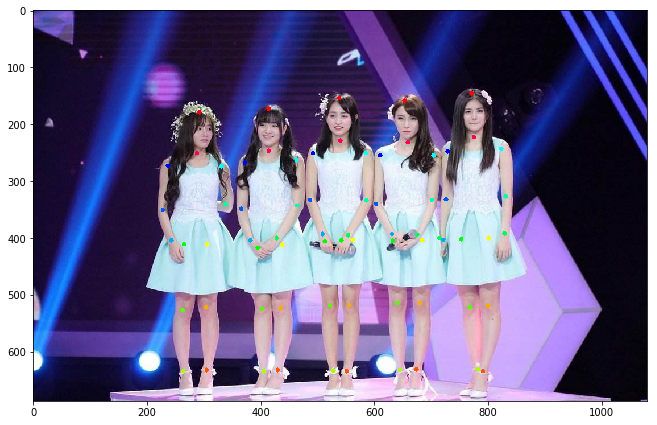

In [88]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

cmap = matplotlib.cm.get_cmap('hsv')

canvas = cimgRGB # B,G,R order

for i in range(14):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv.addWeighted(cimgRGB, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 11)

In [89]:
all_peaks[13]

[(775, 223, 0.62139752507209778, 66),
 (540, 229, 0.73735165596008301, 67),
 (659, 232, 0.66534113883972168, 68),
 (414, 247, 0.72589923441410065, 69),
 (288, 251, 0.6901596337556839, 70)]

In [90]:
mid_1 = [1, 2, 4, 5, 1, 7, 8,  4, 10, 11, 13, 1, 4]
mid_2 = [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 14, 14]
newslist = [[x,y] for x, y in zip(mid_1, mid_2)]
newslist

[[1, 2],
 [2, 3],
 [4, 5],
 [5, 6],
 [1, 7],
 [7, 8],
 [8, 9],
 [4, 10],
 [10, 11],
 [11, 12],
 [13, 14],
 [1, 14],
 [4, 14]]

In [91]:
mapidx1 = range(1, 27, 2)
mapidx2 = range(2, 28, 2)
mapid = [[x,y] for x, y in zip(mapidx1, mapidx2)]
mapid = mapid[3:]+mapid[0:3]
mapid

[[7, 8],
 [9, 10],
 [11, 12],
 [13, 14],
 [15, 16],
 [17, 18],
 [19, 20],
 [21, 22],
 [23, 24],
 [25, 26],
 [1, 2],
 [3, 4],
 [5, 6]]

In [92]:
len(newslist)

13

In [93]:
mapid[0][0]

7

In [94]:
all_peaks

[[(729, 248, 0.62704704701900482, 0),
  (492, 251, 0.64643009006977081, 1),
  (610, 255, 0.63833825290203094, 2),
  (372, 268, 0.52472487837076187, 3),
  (237, 273, 0.63024890422821045, 4)],
 [(726, 332, 0.40731088072061539, 5),
  (487, 333, 0.59284679591655731, 6),
  (603, 340, 0.49921593070030212, 7),
  (366, 349, 0.5794459655880928, 8),
  (228, 351, 0.58462294936180115, 9)],
 [(509, 393, 0.41741782426834106, 10),
  (631, 393, 0.47576891630887985, 11),
  (721, 403, 0.35959809832274914, 12),
  (243, 404, 0.56595370173454285, 13),
  (382, 404, 0.52520367503166199, 14)],
 [(823, 243, 0.65877558290958405, 15),
  (585, 251, 0.66254702210426331, 16),
  (704, 255, 0.60126567631959915, 17),
  (463, 263, 0.67263408005237579, 18),
  (331, 274, 0.61381052434444427, 19)],
 [(831, 327, 0.57398952543735504, 20),
  (701, 333, 0.51415448635816574, 21),
  (586, 334, 0.4626276046037674, 22),
  (338, 341, 0.35478738695383072, 23),
  (464, 343, 0.48106667399406433, 24)],
 [(829, 392, 0.52441865205764771

In [95]:
if 1:
    # find connection in the specified sequence, center 29 is in the position 15
    limbSeq = newslist
    # the middle joints heatmap correpondence
    mapIdx = mapid

    connection_all = []
    special_k = []
    special_non_zero_index = []
    mid_num = 11

    for k in range(len(mapIdx)):
        
        score_mid = paf_avg[:,:,[x-1 for x in mapIdx[k]]]
        candA = all_peaks[limbSeq[k][0]-1]
        candB = all_peaks[limbSeq[k][1]-1]
        # print(k)
        # print(candA)
        # print('---------')
        # print(candB)
        # print limbSeq[k][0], limbSeq[k][1]
        nA = len(candA)
        nB = len(candB)
        indexA, indexB = limbSeq[k]
        if(nA != 0 and nB != 0):
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    # print('vec: ',vec)
                    norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                    # print('norm: ', norm)
                    vec = np.divide(vec, norm)
                    # print('normalized vec: ', vec)
                    startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num))
                    # print('startend: ', startend)
                    vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                      for I in range(len(startend))])
                    # print('vec_x: ', vec_x)
                    vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                      for I in range(len(startend))])
                    # print('vec_y: ', vec_y)
                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    # print(score_midpts)
                    # print('score_midpts: ', score_midpts)
                    score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*cimage.shape[0]/norm-1, 0)

                    # print('score_with_dist_prior: ', score_with_dist_prior)
                    criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.5 * len(score_midpts)
                    # print('score_midpts > param["thre2"]: ', len(np.nonzero(score_midpts > param['thre2'])[0]))
                    criterion2 = score_with_dist_prior > 0

                    '''
                    if k==1 or k==2:
                        criterion2 = score_with_dist_prior > 1
                    if k == 2:
                        print '-----------', i, j
                        print criterion1
                        print criterion2
                        print score_with_dist_prior
                        print score_midpts
                    '''
                    if criterion1 and criterion2:
                        # print('match')
                        # print(i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2])
                        connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
                    # print('--------end-----------')
            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            # print('-------------connection_candidate---------------')
            # print(connection_candidate)
            # print('------------------------------------------------')
            connection = np.zeros((0,5))
            for c in range(len(connection_candidate)):
                i,j,s = connection_candidate[c][0:3]
                if(i not in connection[:,3] and j not in connection[:,4]):
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    # print('----------connection-----------')
                    # print(connection)
                    # print('-------------------------------')
                    if(len(connection) >= min(nA, nB)):
                        break

            connection_all.append(connection)
        elif(nA != 0 or nB != 0):
            #print 'k: ', special_k
            special_k.append(k)
            special_non_zero_index.append(indexA if nA != 0 else indexB)
            connection_all.append([])

    #print connection_all
    # last number in each row is the total parts number of that person
    # the second last number in each row is the score of the overall configuration
    subset = -1 * np.ones((0, 16))

    candidate = np.array([item for sublist in all_peaks for item in sublist])

    # print len(connection_all)
    # print len(mapIdx)
    print 'special_k:', special_k
    for k in range(len(mapIdx)):
        if k not in special_k:
            
            try:
                partAs = connection_all[k][:,0]
                partBs = connection_all[k][:,1]
                indexA, indexB = np.array(limbSeq[k]) - 1

                for i in range(len(connection_all[k])): #= 1:size(temp,1)
                    
                    found = 0
                    subset_idx = [-1, -1]
                    for j in range(len(subset)): #1:size(subset,1):
                        if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                            subset_idx[found] = j
                            found += 1

                    if found == 1:
                        j = subset_idx[0]
                        if k==2:
                            print 'j ', j
                        if(subset[j][indexB] != partBs[i]):#subset[j][indexB] != partBs[i]):
                            if k==2:
                                print 'j ', j
                            subset[j][indexB] = partBs[i]
                            subset[j][-1] += 1
                            subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                    elif found == 2: # if found 2 and disjoint, merge them
                        j1, j2 = subset_idx
                        print "found = 2"
                        membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                        if len(np.nonzero(membership == 2)[0]) == 0: #merge
                            subset[j1][:-2] += (subset[j2][:-2] + 1)
                            subset[j1][-2:] += subset[j2][-2:]
                            subset[j1][-2] += connection_all[k][i][2]
                            subset = np.delete(subset, j2, 0)
                        else: # as like found == 1
                            subset[j1][indexB] = partBs[i]
                            subset[j1][-1] += 1
                            subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                    # if find no partA in the subset, create a new subset
                    elif not found and k < 13:
                        row = -1 * np.ones(16)
                        row[indexA] = partAs[i]
                        row[indexB] = partBs[i]
                        row[-1] = 2
                        row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                        subset = np.vstack([subset, row])
                    if k==2:
                        print 'k ', found
            except:
                print k
            
    # delete some rows of subset which has few parts occur
    deleteIdx = [];
    
    #for i in range(len(subset)):
    #    if subset[i][-1] < 3 or subset[i][-2]/subset[i][-1] < 0.2:
    #        deleteIdx.append(i)
    subset = np.delete(subset, deleteIdx, axis=0)

    #print candidate
    #print subset


special_k: []
k  0
k  0
k  0
k  0
k  0
found = 2
found = 2
found = 2
found = 2
found = 2
found = 2
found = 2
found = 2
found = 2
found = 2


In [96]:
connection_all

[array([[ 4.        ,  9.        ,  1.01588408,  4.        ,  4.        ],
        [ 3.        ,  8.        ,  0.99607443,  3.        ,  3.        ],
        [ 1.        ,  6.        ,  0.97805077,  1.        ,  1.        ],
        [ 0.        ,  5.        ,  0.947749  ,  0.        ,  0.        ],
        [ 2.        ,  7.        ,  0.90229811,  2.        ,  2.        ]]),
 array([[  9.        ,  13.        ,   1.17303648,   4.        ,   3.        ],
        [  8.        ,  14.        ,   1.10757265,   3.        ,   4.        ],
        [  6.        ,  10.        ,   1.0819075 ,   1.        ,   0.        ],
        [  7.        ,  11.        ,   1.0210344 ,   2.        ,   1.        ],
        [  5.        ,  12.        ,   0.94402231,   0.        ,   2.        ]]),
 array([[ 16.        ,  22.        ,   1.00562685,   1.        ,   2.        ],
        [ 18.        ,  24.        ,   0.99253998,   3.        ,   4.        ],
        [ 17.        ,  21.        ,   0.97441643,   2.      

In [97]:
subset[0:5]

array([[  4.        ,   9.        ,  13.        ,  19.        ,
         23.        ,  -1.        ,  34.        ,  40.        ,
         44.        ,  49.        ,  54.        ,  57.        ,
         65.        ,  70.        ,  19.19236191,  13.        ],
       [  3.        ,   8.        ,  14.        ,  18.        ,
         24.        ,  28.        ,  35.        ,  39.        ,
         45.        ,  50.        ,  55.        ,  58.        ,
         64.        ,  69.        ,  19.90868123,  14.        ],
       [  1.        ,   6.        ,  10.        ,  16.        ,
         22.        ,  27.        ,  33.        ,  37.        ,
         43.        ,  47.        ,  52.        ,  59.        ,
         62.        ,  67.        ,  20.54470471,  14.        ],
       [  0.        ,   5.        ,  12.        ,  15.        ,
         20.        ,  25.        ,  30.        ,  38.        ,
         41.        ,  46.        ,  53.        ,  60.        ,
         61.        ,  66.        ,  

In [98]:
subset[6:10]

array([], shape=(0, 16), dtype=float64)

In [99]:
subset[11:15]

array([], shape=(0, 16), dtype=float64)

In [100]:
len(subset)

5

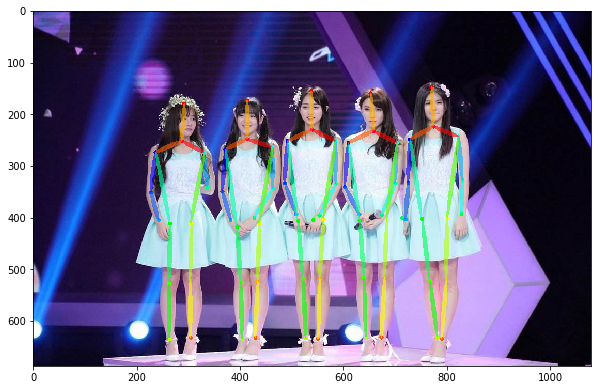

In [101]:
# visualize 2
stickwidth = 4

for i in range(13):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:, :, [2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)